变分自编码器（Variational AutoEncoder,VAE）是生成式模型的一种，另一种常见的生成式模型是生成式对抗网络(Generative Adversarial Network, GAN)。

# 加载库

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda
from keras.models import Model
import keras.backend as K
from keras import objectives
from keras.datasets import mnist

## 常量定义

In [3]:
batch_size = 100
original_dim = 784
intermediate_dim = 256
latent_dim = 2
epochs = 50

## encoder部分，两层全连接层，隐层表示包括均值和方差

In [4]:
x = Input(shape=(original_dim, ))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

Instructions for updating:
Colocations handled automatically by placer.


## lambda层不参与训练，只参与计算，用于后面产生新的z

In [5]:
def sampleing(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.)
    return z_mean + K.mean(z_log_var / 2) *epsilon
z = Lambda(sampleing, output_shape=(latent_dim,))([z_mean, z_log_var])

## decoder，两层全连接层，x_decoded_mean为重构的输出

In [6]:
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

## 自定义总的损失函数并编译模型


In [7]:
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = -0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss
vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)

## 加载数据并训练


In [10]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape(len(x_train), np.prod(x_train.shape[1:]))
x_test = x_test.reshape(len(x_test), np.prod(x_test.shape[1:]))

vae.fit(x_train, x_train,
       shuffle=True,
       epochs=epochs,
       batch_size=batch_size,
       validation_data=(x_test,x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 5s 86us/step - loss: 3709.4771 - val_loss: 174.7678
Epoch 2/50
60000/60000 [==============================] - 5s 85us/step - loss: 166.9656 - val_loss: 161.4029
Epoch 3/50
60000/60000 [==============================] - 5s 84us/step - loss: 159.3644 - val_loss: 156.1154
Epoch 4/50
60000/60000 [==============================] - 5s 84us/step - loss: 155.0466 - val_loss: 153.1713
Epoch 5/50
60000/60000 [==============================] - 5s 85us/step - loss: 152.3946 - val_loss: 151.4919
Epoch 6/50
60000/60000 [==============================] - 5s 85us/step - loss: 150.4879 - val_loss: 150.1901
Epoch 7/50
60000/60000 [==============================] - 5s 85us/step - loss: 149.0960 - val_loss: 149.1922
Epoch 8/50
60000/60000 [==============================] - 5s 85us/step - loss: 148.0174 - val_loss: 147.5891
Epoch 9/50
60000/60000 [==============================] - 5s 87us/step - loss

## 展示encoder

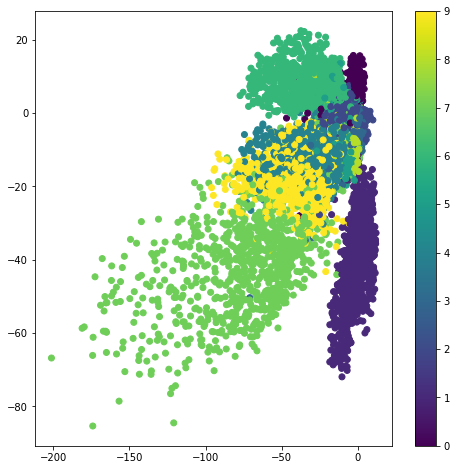

In [12]:
encoder = Model(x, z_mean)
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(8,8))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

## 定义生成器，从隐层到输出，用于产生新的样本

In [13]:
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

## 用网格方法产生一些二维数据，作为新的z输入到生成器，并将生成的x展示出来

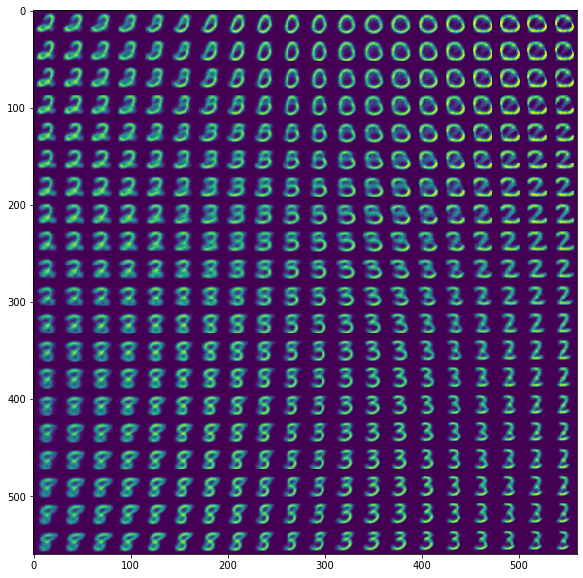

In [19]:
n = 20
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)

for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        z_sample = np.array([[yi, xi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[(n - i - 1) * digit_size : (n-i) * digit_size, 
               j * digit_size:(j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

# FashionMNIST

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 7s 110us/step - loss: 302.8557 - val_loss: 282.4039
Epoch 2/50
60000/60000 [==============================] - 6s 105us/step - loss: 277.2041 - val_loss: 276.2239
Epoch 3/50
60000/60000 [==============================] - 5s 89us/step - loss: 273.3545 - val_loss: 273.8621
Epoch 4/50
60000/60000 [==============================] - 6s 92us/step - loss: 271.5659 - val_loss: 272.7193
Epoch 5/50
60000/60000 [==============================] - 6s 92us/step - loss: 270.3611 - val_loss: 270.8609
Epoch 6/50
60000/60000 [==============================] - 6s 94us/step - loss: 269.3544 - val_loss: 270.7759
Epoch 7/50
60000/60000 [==============================] - 6s 93us/step - loss: 268.5098 - val_loss: 270.9347
Epoch 8/50
60000/60000 [==============================] - 6s 94us/step - loss: 267.8751 - val_loss: 269.4747
Epoch 9/50
60000/60000 [==============================] - 6s 96us/step - los

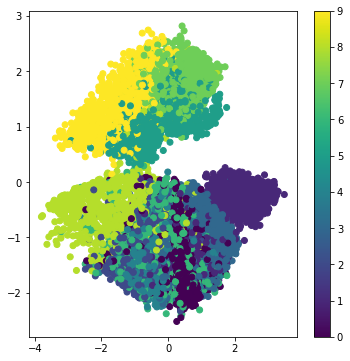

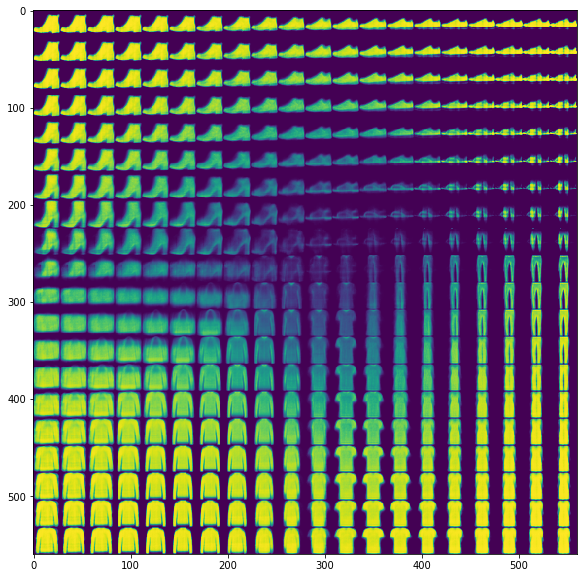

In [27]:
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import fashion_mnist

batch_size = 100
original_dim = 784
intermediate_dim = 256
latent_dim = 2
epochs = 50

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

encoder = Model(x, z_mean)

x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

n = 20
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)

for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        z_sample = np.array([[yi, xi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[(n - i - 1) * digit_size: (n - i) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()